# Compute the probability of future hazards

This notebooks goes through all the steps to produce the hazard likelihood for a future climate indicator at a weather station. It displays intermediate results so they can be reviewed and used to generate custom figures. The steps outlined below expose what is done in the graphical user interface and in the backend. It is also a mean of customizing the calculations and the figures.

In [2]:
# Import libraries
import os
import s3fs

# Computations
import numpy as np
import scipy.stats
import pandas as pd
import xarray as xr
import xclim as xc

# Graphics
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import figanos.matplotlib as fg

In [3]:
# Set options
fg.utils.set_mpl_style('ouranos')
matplotlib.rcParams["legend.title_fontsize"] = 10
matplotlib.rcParams["legend.fontsize"] = 'small'

xc.set_options(metadata_locales=["fr"])
xr.set_options(keep_attrs=True)

## Load ESPO-G6-AHCCD and AHCCD data

AHCCD stands for the Adjusted Historical Canadian Climate Data, and consists in station records that have been quality controlled and adjusted to allow trend analysis. It is stored on Ouranos' THREDDS server in NetCDF format.

ESPO-G6-AHCCD data is an ensemble of CMIP6 global climate model (GCM) simulations that we bias-adjusted using the AHCCD data as a reference. The data is stored in a Zarr format on the Ouranos MinIO server. It includes simulations from four Shared Socioeconomic Pathways (SSP) (SSP1-2.6, SSP2-4.5, SSP3-7.0 and SSP5-8.5), dozens of GCMs, and multiple realizations (or members) for each GCM. This dataset is also available as NetCDF files on the [Federated Research Data Repository (FRDR)](https://doi.org/10.20383/103.01272).

Note that loading the datasets will take a few seconds.

In [4]:
def read_from_minio(filename: str):
    """Read Zarr object from MinIO and return as xarray dataset.

    Parameters
    ----------
    filename: str
      Path to the Zarr object in the portail-ing bucket on the Ouranos MinIO server.
    """
    s3r = s3fs.S3FileSystem(anon=True, use_ssl=False, client_kwargs={"endpoint_url": "http://minio.ouranos.ca"})
    root = f"portail-ing/{filename}"
    store = s3fs.S3Map(root=root, s3=s3r, check=False)
    return xr.open_zarr(store=store)

In [5]:
espo = {
    "tas": read_from_minio('portail_ing_tas_CMIP6_stations_AHCCD_concat.zarr')['tas'],
    "tasmin": read_from_minio('portail_ing_tasmin_CMIP6_stations_AHCCD_concat.zarr')['tasmin'],
    "tasmax": read_from_minio('portail_ing_tasmax_CMIP6_stations_AHCCD_concat.zarr')['tasmax'],
    "pr": read_from_minio('portail_ing_pr_CMIP6_stations_AHCCD_concat.zarr')['pr'],
}

ahccd = {
    "tas": xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml')['tas'],
    "tasmin": xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml')['tasmin'],
    "tasmax": xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml')['tasmax'],
    "pr": xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen2_precipitation.ncml')['pr'],
}

## Select variables and station

Now we pick an AHCCD station and a variable to be used as an input for climate indicator computations. As described in the introduction, indicators can be computed by the backend by sending an HTTP request. Here, we're going to use `xclim` instead, which supports many more indicators than the current backend.


In [6]:
# The variable we'll need for indicator computations, here surface temperature.
var = 'tas'

# Array of station names
names = xr.DataArray(data=espo[var].station.data, coords={"name": espo[var].station_name.data}, dims="name")

# Find station ID from name
station = names.sel(name="MONTREAL__TRUDEAU_IN").item()

# Select DataArrays for the variable and station
da_espo = espo[var].sel(station=station)
da_ahccd = ahccd[var].sel(station=station)

## Compute indicator

Here we're computing heating degree-days, a simple temperature-based indicator evaluating the energy required for heating homes and offices. We're using the `xclim` library, which offers well over 50 different climate indicators, the full list of available indicators can be found in the [xclim documentation](https://xclim.readthedocs.io/en/stable/indicators.html).

We'll compute the indicator for both the observed temperature (AHCCD) and the GCM simulated temperature (ESPO-G6-AHCCD). Depending on your internet bandwidth, this can take a few seconds to a few minutes.


In [7]:
# Heating degree days under 18°C
ind_espo = xc.indicators.atmos.heating_degree_days(da_espo, thresh='18.0 degC', freq='YS').load()
ind_ahccd = xc.indicators.atmos.heating_degree_days(da_ahccd, thresh='18.0 degC', freq='YS').load()

/home/david/.conda/envs/ing11/lib/python3.11/site-packages/xclim/core/cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])


Text(0.5, 0, '')

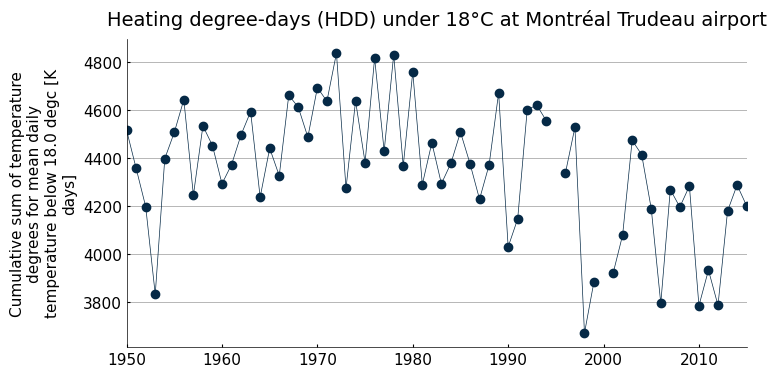

In [8]:
# Simple graphics of observed HDD
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ind_ahccd.sel(time=slice("1950", "2015")).plot(marker="o", label='ESPO-G6-AHCCD', lw=.5, ax=ax)
ax.set_title("Heating degree-days (HDD) under 18°C at Montréal Trudeau airport")
ax.set_xlabel("")

## Risk analysis

In the following, we'll fit statistical distributions to the observed and simulated indicator, then combine this information into a single probability distribution describing the probability density of HDD in the future. We'll then be able to compute how likely it is that HDD will exceed a given threshold in the future.

The code below uses the same logic as the web interface, hence the reference to the `frontend`.

### User inputs

Let's first set the analysis requirements:

reference period
: Start and end year of the period used to fit the distributions to the observed data and serving as a baseline for the simulations. Could refer to the year the infrastructure was build, for instance if the infrastruscture was build in 1995 the reference period would be 1981-2010.

future period
: Start and end year of the period used to fit the distributions to the future simulated data. Could refer to the infrastructure service life, for instance if the infrastruscture was build in 1995 and its lifespan is of 70 years, the future period would be 2051-2080.

distributions
: The list of distributions to fit to the observed data to try and find the one best matching the indicator. Use the names of the SciPy package distributions.

metric
: The metric used to pick the best distribution. For now, we only have two metrics available: the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). The lower the value, the better the fit.

level
: The significance level for the p-value of the Kolmogorov-Smirnov test. This is used to determine whether the observed and simulated data are statistically different. A value of 0.05 means that we accept a 5% chance of rejecting the null hypothesis when it is true.


In [ ]:
# Import analysis classes and functions
import peach.frontend.parameters
from peach.frontend.parameters import IndicatorObsDA, IndicatorRefDA, IndicatorSimDA, HazardMatrix, HazardThreshold
from peach.risk.priors import scenario_weights_from_iams

# Reference and future periods
ref_period = (1980, 2009)
fut_period = (2050, 2079)

# Distribution families
scipy_dists = ["norm", "t", "gamma", "genextreme", "lognorm", "uniform"]

# Metric to pick the best fitting distribution against observations ('bic' or 'aic')
metric = 'bic'

# Significance level for Kolmogorov-Smirnov test
level = 0.05

### Fit observed indicator values

The idea here is to find a distribution that describes the sample of observed indicators over the reference period, and then assume that simulated indicators can be described by the same distribution, but with different parameters. So the first step is to identify a distribution family. This is done by the `best_dist` method of the `IndicatorObsDA` class.


In [232]:
# Instantiate the class
obs = IndicatorObsDA(data=ind_ahccd, period=ref_period)

# Compute the best distribution
best = obs.best_dist()

# Create a table with the metric values
bic = pd.Series(obs.metrics_da, index=obs.metrics_da.scipy_dist, name=metric.upper())
bic.sort_values(ascending=True, inplace=True)
bic

2025-06-02 09:52:54,270 | INFO | portail_ing.frontend.parameters | lmom: norm, <lmoments3.distr.NormGen object at 0x7f830e7ebb10> PWM
2025-06-02 09:52:54,274 | INFO | portail_ing.frontend.parameters | fit: [4297.59642857  270.68816741] 
2025-06-02 09:52:54,282 | INFO | portail_ing.frontend.parameters | lmom: t, t ML
2025-06-02 09:52:54,419 | INFO | portail_ing.frontend.parameters | fit: [52045.43890394  4297.52114127   262.89678825] 
2025-06-02 09:52:54,425 | INFO | portail_ing.frontend.parameters | lmom: gamma, <lmoments3.distr.GammaGen object at 0x7f830ec33a50> PWM
2025-06-02 09:52:54,429 | INFO | portail_ing.frontend.parameters | fit: [251.81509087   0.          17.06647689] 
2025-06-02 09:52:54,439 | INFO | portail_ing.frontend.parameters | lmom: genextreme, <lmoments3.distr.GenextremeGen object at 0x7f830e7dd590> PWM
2025-06-02 09:52:54,443 | INFO | portail_ing.frontend.parameters | fit: [5.12437134e-01 4.23231942e+03 2.95219083e+02] 
2025-06-02 09:52:54,450 | INFO | portail_ing.f

/home/david/.conda/envs/ing11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/david/.conda/envs/ing11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/david/.conda/envs/ing11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/david/.conda/envs/ing11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


norm          398.332774
uniform       398.375234
genextreme    399.342305
t             401.687443
lognorm       401.687614
gamma         402.364257
Name: BIC, dtype: float64

According to the BIC, the best distribution is the uniform distribution, but that sounds fishy. We'll plot a histogram of the indicator values and the first three best fitting distributions to see if another option would make more sense.

2025-06-02 09:52:54,957 | INFO | portail_ing.frontend.parameters | lmom: uniform, uniform ML
2025-06-02 09:52:54,961 | INFO | portail_ing.frontend.parameters | fit: [3670.2 1088.3] 
2025-06-02 09:52:54,969 | INFO | portail_ing.frontend.parameters | lmom: genextreme, <lmoments3.distr.GenextremeGen object at 0x7f830e7dd590> PWM
2025-06-02 09:52:54,975 | INFO | portail_ing.frontend.parameters | fit: [5.12437134e-01 4.23231942e+03 2.95219083e+02] 
2025-06-02 09:52:54,984 | INFO | portail_ing.frontend.parameters | lmom: norm, <lmoments3.distr.NormGen object at 0x7f830e7ebb10> PWM
2025-06-02 09:52:54,987 | INFO | portail_ing.frontend.parameters | fit: [4297.59642857  270.68816741] 


Text(0, 0.5, 'Probability density (°C$^{-1}$)')

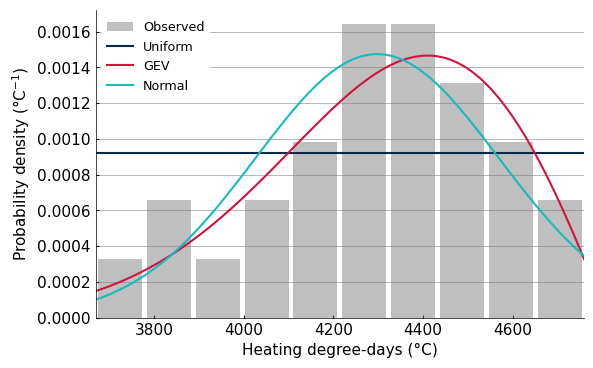

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(6.3,4))

# Histogram
ax.hist(obs.sample, density=True, alpha=.5, rwidth=.9, color='grey', label='Observed')

x = np.linspace(obs.sample.min().item(), obs.sample.max().item(), 100)
x = xr.DataArray(data=x, dims=(obs.sample.name,), coords={obs.sample.name: x})
labels = {"uniform": "Uniform", "genextreme": "GEV", "norm": "Normal"}

for d in ['uniform', 'genextreme', 'norm']:
    # PDF
    pdf = IndicatorObsDA(data=ind_ahccd, period=ref_period, dist=d).pdf(x)
    ax.plot(x, pdf, label=labels[d])

ax.legend()
ax.set_xlabel('Heating degree-days (°C)')
ax.set_ylabel('Probability density (°C$^{-1}$)')

In the following, we'll use the GEV distribution (genextreme) since visually it captures better the shape of the distribution. The BIC may prefer the uniform distribution since it has only two parameters, compared to GEV's three.

Now that we've selected the distribution family, we'll fit it to the simulated samples over the reference and future periods. The simulations include four greenhouse gas (GHG) scenarios (SSP1-2.6, SSP2-4.5, SSP3-7.0 and SSP5-8.5), dozens of GCMs, and multiple realizations (or members) for each GCM. For a given SSP, the fit is done on all realizations from the same model, so that we have one pdf per model and scenario. We then assign weights to these pdfs, according to the performance of the model in reproducing the observed data, the climate sensitivity of the model, and the likelihood of the GHG scenario. The next cells describe in a bit more details how these weights are computed and what they look like.

### Model weights based on performance

We want to make sure that the simulations are consistent with observations. Our first set of weights (w1) are just zeros and ones indicating whether the simulation passes the 2-sample Kolmogorov-Smirnov (KS) test. This test checks whether our observed data and the simulated data are drawn from the same distribution. If they are, we assign a weight of 1 to the model, otherwise we assign a weight of 0. The KS test measures the maximum *distance* between the empirical cumulative distribution function (CDF) of two distributions. If this distance is below a certain threshold (defined by the significance level), we consider that the two samples are drawn from the same distribution.

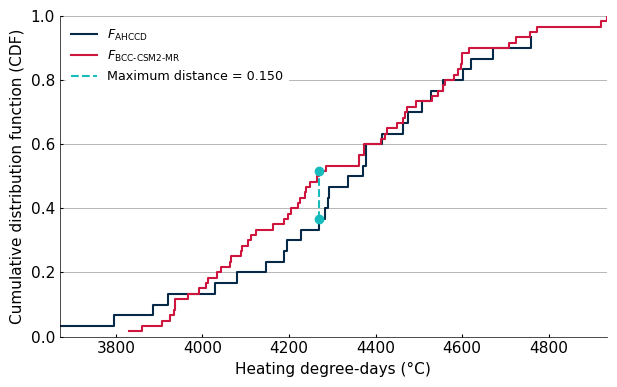

In [234]:
# Observed dataset
data1 = ind_ahccd.sel(time=slice(str(ref_period[0]), str(ref_period[1]))).values

# Simulated dataset for one model
model = 'BCC-CSM2-MR'
data2 = np.concatenate(ind_espo[ind_espo.source_id.values==model].sel(time=slice(str(ref_period[0]), str(ref_period[1]))).values)

# Calculate ECDFs
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x1, y1 = ecdf(data1)
x2, y2 = ecdf(data2)

# Perform KS test to find Dmax
ks_stat, _ = scipy.stats.ks_2samp(data1, data2)
dmax_x = np.linspace(min(max(x1), max(x2)), max(min(x1), min(x2)), 1000)
dmax_y1 = np.interp(dmax_x, x1, y1, left=0, right=1)
dmax_y2 = np.interp(dmax_x, x2, y2, left=0, right=1)
dmax_idx = np.argmax(np.abs(dmax_y1 - dmax_y2))
dmax = np.abs(dmax_y1[dmax_idx] - dmax_y2[dmax_idx])

# Plot the ECDFs and Dmax
plt.figure(figsize=(6.3, 4))
plt.step(x1, y1, label=r"$F_{\text{AHCCD}}$", where='post')
plt.step(x2, y2, label=fr"$F_{{\text{{{model}}}}}$", where='post')
vline = plt.vlines(dmax_x[dmax_idx], dmax_y1[dmax_idx], dmax_y2[dmax_idx], linestyle='--', label=f'Maximum distance = {dmax:.3f}', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
vline_colors = vline.get_colors()
plt.scatter([dmax_x[dmax_idx]] * 2, [dmax_y1[dmax_idx], dmax_y2[dmax_idx]], color=vline_colors, zorder=5)
plt.xlabel('Heating degree-days (°C)')
plt.ylabel('Cumulative distribution function (CDF)')
plt.legend()
plt.ylim(0,1)
plt.tight_layout()

In [235]:
# Fit the distribution to the simulated data for the reference and future periods
obs.dist = "genextreme"
ref = IndicatorRefDA(data=ind_espo, obs=obs, level=level, dist='genextreme')

fut = IndicatorSimDA(data=ind_espo, period=fut_period, obs=obs, model_weights=ref.model_weights, dist='genextreme')

# Kolmogorov-Smirnov between observed and simulated data for reference period
print(f"Number of models that passed the ks test: {(ref._ks == True).sum().item()}")
print(f"Number of models that failed the ks test: {(ref._ks == False).sum().item()}")

2025-06-02 09:52:56,229 | INFO | portail_ing.frontend.parameters | lmom: genextreme, <lmoments3.distr.GenextremeGen object at 0x7f830e7dd590> PWM
2025-06-02 09:52:56,232 | INFO | portail_ing.frontend.parameters | fit: [5.12437134e-01 4.23231942e+03 2.95219083e+02] 
2025-06-02 09:53:07,201 | INFO | portail_ing.frontend.parameters | : Model weights computed
Number of models that passed the ks test: 21
Number of models that failed the ks test: 10


### Model weights based on Equilibrium Climate Sensitivity (ECS)

The second set of weights (w2) are based on the ECS of each model. The ECS is a measure of how much the Earth's temperature will increase in response to a doubling of CO2 concentration in the atmosphere. Information from paleoclimatology and recent observations have provided us with a probability distribution for the value of this ECS. However, it appears that the CMIP6 ensemble is not a representative sample of this ECS distribution; it has a high proportion of models with high ECS. Taking an unweighted average of CMIP6 temperature change would lead to a hot bias. Here, we take the sample of models that passed the KS test and assign them a weight to ensure that their distribution of ECS is consistent with the expected ECS distribution.


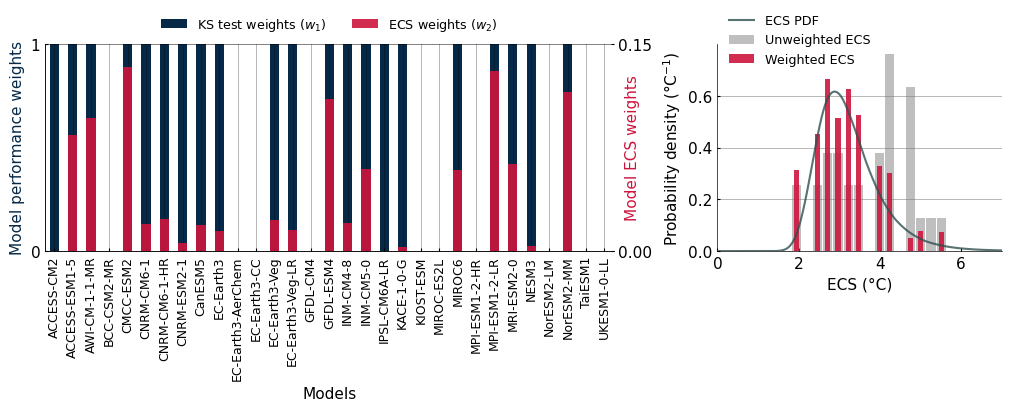

In [ ]:
from peach.risk.priors import load_sherwood_ecs

# Weights (0/1) based on the K-S test
w1 = ref._ks.to_series() * 1

# Weights based on the ECS and GHG scenario
w2 = ref.model_weights.to_series()


ecs = ref.model_weights.coords['ecs'].values

w = pd.DataFrame({'KS test ($w_1$)': w1, 'ECS ($w_2$)': w2}).copy()
w.index.rename("Models", inplace=True)

fig, axd = plt.subplot_mosaic([['left', 'left', 'right']],
                              figsize=(10, 4), layout="constrained")

ecs_df = load_sherwood_ecs()
pdf = xr.DataArray(ecs_df["pdf"], dims="ecs", coords={"ecs": ecs_df["ECS"]})

c = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]

for k, ax in axd.items():
    if k == "left":
        ax2 = ax.twinx()
        b1 = w.plot.bar(y="KS test ($w_1$)", label='w2', color=c[0], ax=ax, zorder=-10, legend=False)
        b2 = w.plot.bar(y="ECS ($w_2$)", label='w1', color=c[1], ax=ax2, legend=False, alpha=.9)
        ax.set_ylabel("Model performance weights", color=c[0])
        ax.set_yticks([0, 1])
        ax.set_ylim(0, 1)
        ax2.set_ylabel("Model ECS weights", labelpad=-20, color=c[1])
        fig.draw_without_rendering()
        yt = ax2.get_yticks()
        ax2.set_yticks(yt[[0,-1]])
        ax.xaxis.set_tick_params(labelsize=9)
        ax.legend(labels=["KS test weights ($w_1)$", "ECS weights ($w_2$)"], handles=[b1.get_children()[0], b2.get_children()[0]], loc='lower center', bbox_to_anchor=(.5, 1), ncols=2)

    if k == "right":
        pdf.plot(ax=ax, color='darkslategray', alpha=0.8, label="ECS PDF", zorder=10)
        ax.hist(ecs, density=True, bins=15, color='grey', alpha=0.5, label="Unweighted ECS", rwidth=.9)
        ax.hist(ecs, density=True, bins=15, color=c[1], alpha=0.9, label="Weighted ECS",  rwidth=.5, weights=w2)
        ax.set_xlabel("ECS (°C)")
        ax.set_ylabel("Probability density (°C$^{-1}$)")
        ax.set_xlim(0, 7)
        ax.legend(fontsize="small", loc="upper left", bbox_to_anchor=(0, 1.2), framealpha=0)




|### SSP scenario weights

The third set of weights (w3) is based on the likelihood of each GHG scenario. This likelihood is estimated from probabilistic Integrated Assessment Models (IAMs) that simulate the evolution of GHG emissions according to demography, technology and policies. We infer SSP probabilities based on the outputs of five of these IAMs. This is a fairly crude assessment, but we feel it's better than assuming all SSPs are equally likely.

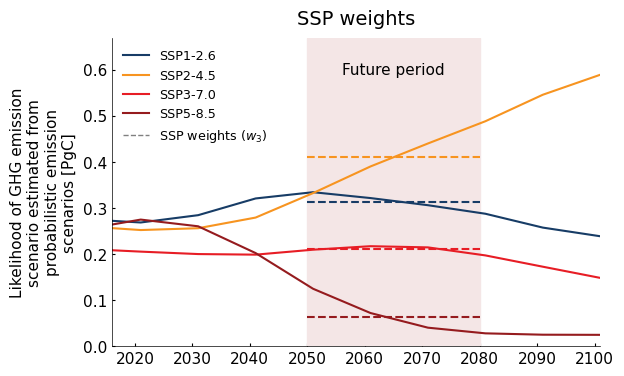

In [262]:
import datetime as dt
# Scenarios weights
scen_weights = scenario_weights_from_iams()

# Compute over the future period
w3 = fut.scenario_weights

#t = matplotlib.dates.date2num(dt.datetime(int(np.mean(fut_period)), 1, 1))
t = matplotlib.dates.date2num(dt.datetime(fut_period[0], 1, 1)), matplotlib.dates.date2num(dt.datetime(fut_period[1], 12, 31))

ssp_label = {
    "ssp126":"SSP1-2.6",
    "ssp245":"SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp585": "SSP5-8.5"
}

ssp_color = {
    "ssp126": (23, 60, 102),
    "ssp245": (247, 148, 32),
    "ssp370": (231, 29, 37),
    "ssp585": (149, 27,30)
}
ssp_color = {k: tuple(v[i] / 255 for i in range(3)) for k, v in ssp_color.items()}

fig, ax = plt.subplots(1, 1, figsize=(6.3,4))
for ssp in scen_weights.experiment_id.values:
    scen_weights.sel(experiment_id=ssp).plot(color=ssp_color[ssp], ax=ax, label=ssp_label[ssp])
    #ax.plot([np.mean(t)], w3.sel(experiment_id=ssp).values, marker='o', color=ssp_color[ssp])
    y = w3.sel(experiment_id=ssp).values
    ax.plot(t, [y, y], ls="--", color=ssp_color[ssp])

ax.plot(t, [-1, -1], color='grey', lw=1, ls='--', label="SSP weights ($w_3$)")
ax.axvspan(t[0], t[1], color="#F4E6E6")
ax.set_title("SSP weights")
ax.text(np.mean(t), .6, 'Future period', ha='center', va='center')
ax.set_xlabel("")
ax.set_ylim(0)
ax.grid(False)
leg = ax.legend()


### Weighted indicators

Now we can combine all these weights and apply them to the simulated data. The figure below shows time series of observed and simulated indicator values with and without weights. The weighted simulations are the ones that will be used to compute the hazard likelihood.

Text(0.5, 0, '')

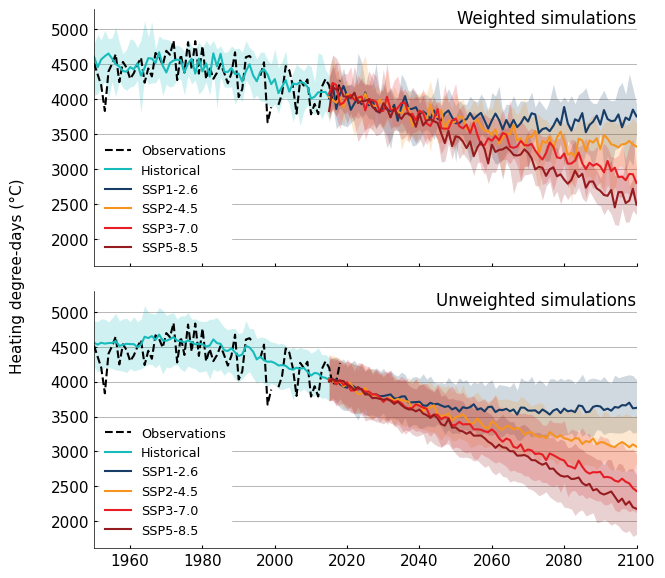

In [28]:
from xclim import ensembles

fig, axs = plt.subplots(2, 1, figsize=(7,7), sharey=True, sharex=True)

percentiles = [10, 50, 90]
plot = {
    'Observations': ind_ahccd.sel(time=slice("1950", "2020"))
}

exp_per = fut.experiment_percentiles(percentiles)

for i in [0, 1]:
    ax = axs[i]

    # Historical period
    if i==0:
        title = "Weighted simulations"
        plot['Historical'] = exp_per.sel(time=slice('1950', '2015'), experiment_id='ssp245')
    else:
        title = "Unweighted simulations"
        plot['Historical'] = ensembles.ensemble_percentiles(
            ind_espo.sel(time=slice('1950', '2015')),
            values=percentiles,
        )

    # Simulations by SSP
    groups = ind_espo.groupby('experiment_id')
    for label, da in groups:
        if i==0:
            plot[label] = exp_per.sel(time=slice('2015', '2100'), experiment_id=label)
        else:
             plot[label] = ensembles.ensemble_percentiles(
                da.sel(time=slice('2015', '2100')),
                values=percentiles,
            )

    # Use Figanos to plot the different time series
    fg.plot.timeseries(
        plot,
        ax=ax,
        show_lat_lon=False,
        plot_kw= {
            'Observations': {'linestyle': '--', 'color': 'k'},
            'Historical': {'color': '#18BBBB',},
        },
    )

    #ax.set_title(title, loc="left")
    ax.set_title("", loc="left")
    ax.text(1, 1, title, ha="right", va="top", fontsize=12, transform=ax.transAxes)
    ax.set_ylabel("")
    if i==0:
        ax.set_xlabel("")

ylab = 'Heating degree-days (°C)'
fig.text(0.005, 0.5, ylab, va='center', rotation='vertical')
plt.subplots_adjust(hspace=0.1)  # Adjust spacing between subplots
ax.set_xlabel("")

### Reference histograms with and without weights

To give a sense of the impact of model weights on the results, the next graphic compares histograms of the observed data with the weighted and unweighted simulations. Since this graphic uses results from the reference period, we don't expect the differences to be very large, because the effect ECS differences should be small, and the GHG scenarios are identical. The only factor really playing a role here is the K-S test, which will filter outsome models that do not match the observed data ECDF.


In [29]:
no_w = IndicatorRefDA(data=ind_espo, obs=obs, level=None, dist='genextreme')
data = {
    'Observations': {
        'observations':  obs,
    },
    'Simulations':
        {
        'Weighted': ref,
        'Unweighted': no_w
        },
}

2025-05-27 12:55:08,689 | INFO | portail_ing.frontend.parameters | : Model weights computed


Text(0.35, 0.004, 'Heating degree-days (°C)')

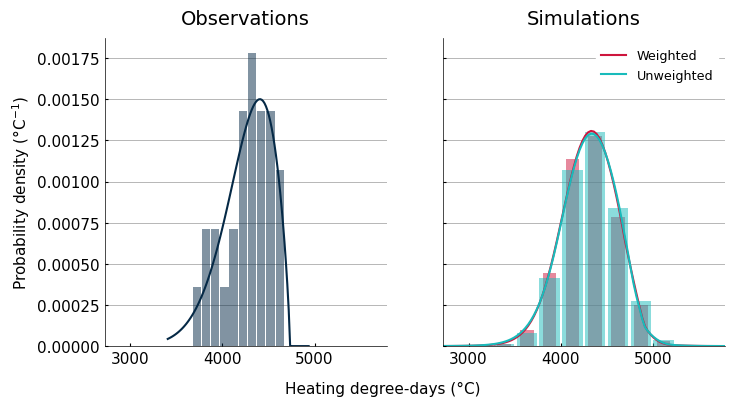

In [30]:
# Plot histogram and PDF

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,4))

c = 0
for k, v in data.items():
    if k=='Observations':
        n = 0
    else:
        n = 1

    for dl, dd in v.items():
        # Histogram
        hist_kw = {
            'color': colors[c],
            'density': True,
            'alpha': 0.5,
            'rwidth': 0.6 if dl == 'Weighted' else 0.9,
        }
        if k=='Simulations':
            val_hist = dd.sample.values.flatten()
            if dl == 'Weighted':
                hist_kw['weights'] = dd.weights.broadcast_like(dd.sample).values.flatten()
        else:
            val_hist = dd.sample.values


        axs[n].hist(val_hist, **hist_kw)

        # PDF
        pdf_kw = {'color': colors[c]}
        sigma = dd.sample.std().item()
        x = np.linspace(dd.sample.min().item() - sigma, dd.sample.max().item() + sigma, 100)
        x = xr.DataArray(data=x, dims=(dd.sample.name,), coords={dd.sample.name: x})
        vals = dd.pdf(x)

        if k=='Simulations':
            pdf_kw['label'] = dl

        axs[n].plot(vals[dd.sample.name].values, vals.values, **pdf_kw)
        c += 1

    axs[n].set_title(k)

    if n==0:
        axs[n].set_ylabel('Probability density (°C$^{-1}$)')
    else:
        axs[n].legend()

fig.text(0.35, 0.004, 'Heating degree-days (°C)', va='center', rotation='horizontal')

### Ensemble distribution mixture

From the hundreds of weighted PDFs, we can now build a distribution mixture combining the information from all the simulations. What we're doing is simply computing statistics, like the PDF or exceedance probability, and computing the weighted average. The next graphic shows the PDF of all the individual simulations, and the resulting weighted PDF (also called mixture).

(0.0, 0.0024291422310623745)

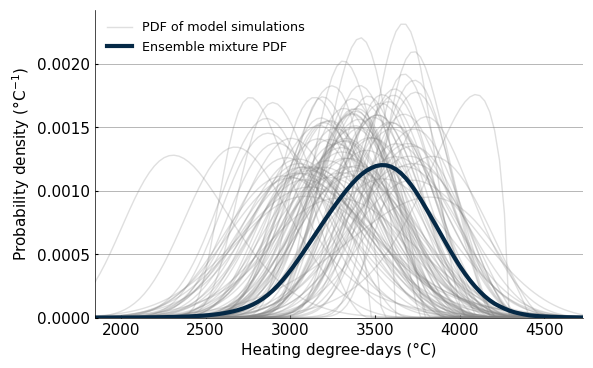

In [ ]:
# Mixture future
x = np.linspace(fut.sample.min().item(), fut.sample.max().item(), 100)
vals = fut.pdf(x).values

#Indiviually compute PDF for visualization
from peach.risk.mixture import parametric_pdf
res = parametric_pdf(fut.dparams.stack(realization=('source_id', 'experiment_id')), x)

# Visualization of future PDFs and weighted Mixture
plt.figure(figsize=(6.3, 4))

for rea in res.realization.values:
    plt_kw = {
        "color": "grey",
        "alpha": 0.25,
        "linewidth": 1,
    }

    if rea == res.realization.values[-1]:
        plt_kw['label'] = "PDF of model simulations"
    plt.plot(x, res.sel(realization=rea).values, **plt_kw)

plt.plot(x, vals, label='Ensemble mixture PDF', color=colors[0], linewidth=3)
plt.legend()
#plt.title(f"Mixture and GCMs simulation PDF for {fut_period[0]}-{fut_period[1]}")
plt.xlabel('Heating degree-days (°C)')
plt.ylabel('Probability density (°C$^{-1}$)')
plt.ylim(bottom=0)

#plt.savefig('pdf_mixture_sims_example.png', dpi=400, bbox_inches='tight')

### Likelihood of exceeding a climate threshold

The same procedure used to compute the weighted PDF can also be used to compute the probability of exceeding a given climate threshold, above which there are consequences for an infrastructure. The results show that exceeding a threshold of 4200 heating degree-days (HDD) is going to be very unlikely. The following graphic shows the survival function, P(X > x) for the observations and simulations, and plots points for a threshold set at 4200 HDD.


In [32]:
h = HazardThreshold(obs=obs, ref=ref, fut=fut, input='X', value=4200, locale='en')
for k, v in h.docs.items():
    if k not in ['xid', 'descr']:
        print(f'{v}: {getattr(h, k):.2f}')

Return period during the reference period: 1.57
Climate threshold value: 4200.00
Exceedance probability during the reference period: 0.64
Exceedance probability during the reference period: 0.65
Exceedance probability during the future period: 0.01
Ratio of future exceedance probability vs reference: -0.98


Text(0.5, 0, 'Heating degree-days (°C)')

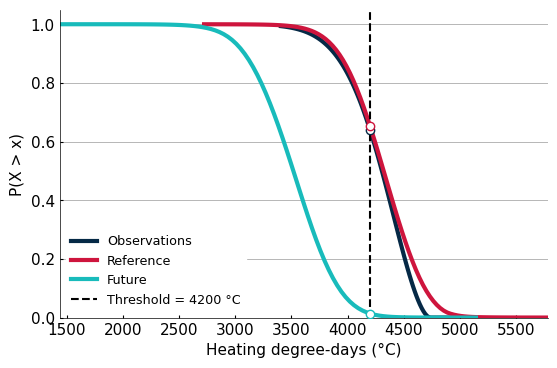

In [33]:
# Survival function and threshold Vizualisation
fig, ax = plt.subplots(1, 1, figsize=(6.3, 4))
n = 0
labels = {'obs': 'Observations', 'ref': 'Reference', 'fut':'Future'}
for k, dd in {'obs':obs, 'ref': ref, 'fut': fut}.items():
    # Survival function P(X > x)
    sigma = dd.sample.std().item()
    x = np.linspace(dd.sample.min().item() - sigma, dd.sample.max().item() + sigma, 100)
    x = xr.DataArray(data=x, dims=(dd.sample.name,), coords={dd.sample.name: x})
    vals = dd.sf(x)
    plt.plot(vals[dd.sample.name].values, vals.values, color=colors[n], label=labels[k], linewidth=3)

    # Threshold value & arrows
    plt.plot(h.value, getattr(h, f"{k}_sf"), markeredgecolor=colors[n], markerfacecolor="white", linewidth=20, marker='o', zorder=10)
    #plt.arrow(threshold['input_value'], 0, 0, getattr(analysis, f"{k}_sf"), zorder=10, overhang=0.2)
    #plt.arrow(threshold['input_value'], getattr(analysis, f"{k}_sf"), -threshold['input_value'], 0, zorder=10, overhang=0.2)
    n+=1

ax.axvline(h.value, color='black', linestyle='--', label=f'Threshold = {h.value} °C')
plt.ylim(bottom=0)
plt.legend()
plt.ylabel('P(X > x)')
plt.xlabel('Heating degree-days (°C)')